# Regression Analysis: Step 3 - Feature Engineering

## Overview
Feature engineering is a critical step aimed at enhancing the predictive power of our model by creating new features or transforming existing ones.

## Process
### 1. Dataset Import
We begin by importing the preprocessed dataset from the previous step. This dataset serves as the foundation for our feature engineering endeavors.

### 2. Creating interaction terms
Identifying the hidden patterns using interaction terms

### 3. Dropping High VIF Features
Similar to Step 2, we conduct a variance inflation factor (VIF) analysis to detect multicollinearity among the engineered features. High VIF features are dropped to mitigate collinearity issues.

### 4. Pipeline Building
We construct a pipeline encompassing feature engineering techniques such as scaling, transformation, and generation of new features. This pipeline ensures consistency and reproducibility in our modeling process.

### 5. Model Building
With the enriched feature set, we proceed to build regression models. We may employ various techniques, including linear regression, polynomial regression, or more advanced algorithms, depending on the complexity of the problem and the nature of the data.

### 6. Results Analysis
Finally, we analyze the performance of the models using appropriate evaluation metrics such as R-squared, mean squared error (MSE), or root mean squared error (RMSE). This step provides insights into the effectiveness of the feature engineering efforts in improving model accuracy and generalization.

## Conclusion
Feature engineering plays a pivotal role in unlocking hidden patterns and relationships within the data, thereby empowering our regression models to make more accurate predictions.

In [56]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [57]:
train_data=pl.read_csv("train_preprocessed.csv")
test_data=pl.read_csv("test_preprocessed.csv")
train_data.shape,test_data.shape

((164, 25), (41, 25))

In [58]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Feature Engineering for Car Dataset

In this section, we describe the feature engineering steps applied to the car dataset. The following new features have been created with the help of Chatgpt's domain knowldege to enhance the predictive power of our model:

## 1. Car Space
The `carspace` feature represents the overall space of the car, calculated using the product of car length, car width, and wheelbase.

$$
\text{carspace} = \text{carlength} \times \text{carwidth} \times \text{wheelbase}
$$

## 2. Average MPG
The `averagempg` feature provides a balanced measure of fuel efficiency, combining city and highway miles per gallon (MPG) using weighted averages.
US Environmental Protection Agency (EPA) uses a standard weighting of 55% city and 45% highway to calculate a combined fuel economy rating for vehicles https://www.epa.gov/fueleconomy

$$
\text{averagempg} = \frac{1}{\frac{0.55}{\text{citympg}} + \frac{0.45}{\text{highwaympg}}}
$$

## 3. Performance Balance
The `performancebalance` feature integrates engine size, horsepower, curb weight, and fuel efficiency, adjusted by peak RPM. It aims to capture a balance between power and efficiency.

$$
\text{performancebalance} = \frac{\text{enginesize} \times \text{horsepower} \times \text{curbweight} \times \text{averagempg}}{\text{peakrpm}}
$$

## 4. Engine Displacement
The `displacement` feature calculates the engine's total displacement volume, incorporating the bore, stroke, and number of cylinders.

$$
\text{displacement} = \pi \times \left(\frac{\text{bore}}{2}\right)^2 \times \text{stroke} \times \text{numberofcylinders}
$$

# Feature Engineering

In [59]:
train_data=train_data.with_columns(((train_data['carlength']*train_data['carwidth']*train_data["wheelbase"])).alias("carspace")).drop("carlength", "carwidth","wheelbase")
train_data=train_data.with_columns((1/((0.55/train_data['citympg'])+(0.45/train_data['highwaympg']))).alias("averagempg")).drop("citympg",'highwaympg')
train_data=train_data.with_columns(((train_data["enginesize"]*train_data['horsepower']*train_data["curbweight"]*train_data["averagempg"]/train_data['peakrpm'])).alias("performancebalance")).drop("peakrpm","horsepower","enginesize","curbweight")
train_data=train_data.with_columns((np.pi*(train_data['boreratio']*train_data["stroke"]/2).pow(2)*train_data['stroke']*train_data['cylindernumber']).alias("enginedisplacement")).drop("stroke","boreratio","cylindernumber")

test_data=test_data.with_columns(((test_data['carlength']*test_data['carwidth']*test_data["wheelbase"])).alias("carspace")).drop("carlength", "carwidth","wheelbase")
test_data=test_data.with_columns((1/((0.55/test_data['citympg'])+(0.45/test_data['highwaympg']))).alias("averagempg")).drop("citympg",'highwaympg')
test_data=test_data.with_columns(((test_data["enginesize"]*test_data['horsepower']*test_data["curbweight"]*test_data["averagempg"]/test_data['peakrpm'])).alias("performancebalance")).drop("peakrpm","horsepower","enginesize","curbweight")
test_data=test_data.with_columns((np.pi*(test_data['boreratio']*test_data["stroke"]/2).pow(2)*test_data['stroke']*test_data['cylindernumber']).alias("enginedisplacement")).drop("stroke","boreratio","cylindernumber")

num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

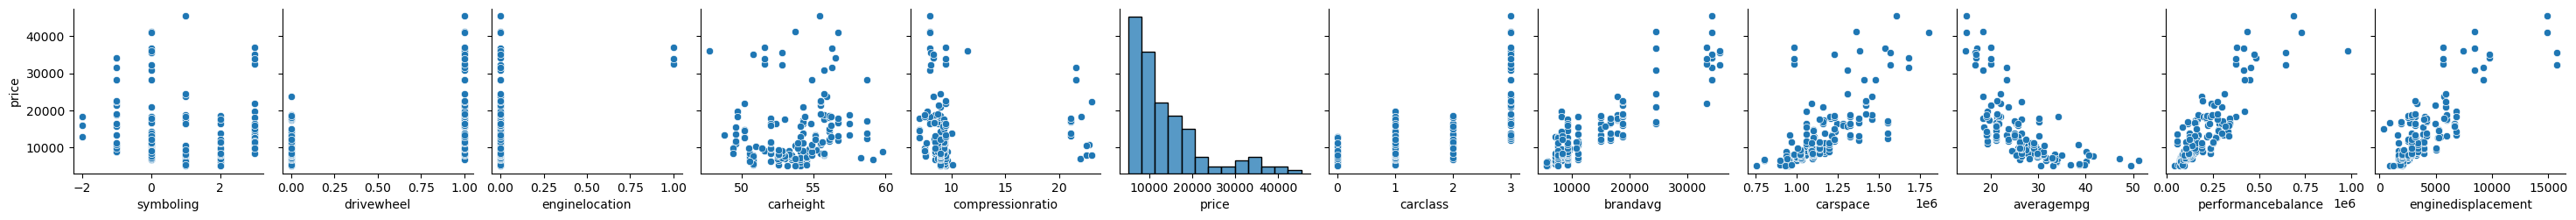

In [60]:
sns.pairplot(data=train_data.drop("car_ID").to_pandas(),y_vars="price")

# Having more domain knowledge may even make use of these remaining features like compression ratio,enginetype etc

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False)

,variables,VIF
0,const,1021.785225
8,carspace,7.848851
7,brandavg,6.701374
10,performancebalance,5.758000
6,carclass,5.558146
11,enginedisplacement,4.503600
9,averagempg,3.681118
4,carheight,2.545349
2,drivewheel,2.190903
1,symboling,1.737848


## dropping low correlated features

In [62]:
train_data[num_cols+["price"]].to_pandas().corr()['price'].sort_values(ascending=False)

price                 1.000000
brandavg              0.898090
performancebalance    0.860656
enginedisplacement    0.815658
carclass              0.723813
carspace              0.697662
drivewheel            0.624632
enginelocation        0.337440
carheight             0.157376
compressionratio      0.075676
symboling            -0.077710
averagempg           -0.702211
Name: price, dtype: float64

In [63]:
train_data=train_data.drop("drivewheel","carheight","compressionratio","symboling")
test_data=test_data.drop("drivewheel","carheight","compressionratio","symboling")
#engine location very few observations so not dropping
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

In [64]:
train_data.write_csv("../Day4_ErrorAnalysis/train_featureEngineered.csv")
test_data.write_csv("../Day4_ErrorAnalysis/test_featureEngineered.csv")

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['enginelocation', 'carclass',
                                                   'brandavg', 'carspace',
                                                   'averagempg',
                                                   'performancebalance',
                                                   'enginedisplacement'])])),
                ('lr', LinearRegression())])

Mean Test Score: 0.8604698542670076
Standard Deviation of Test Scores: 0.09490041217827218
Mean absolute Error: 1404.1997370255558
R-squared on holdout set: 0.893774638583252
Adjusted R-squared on holdout set: 0.8534822601148304


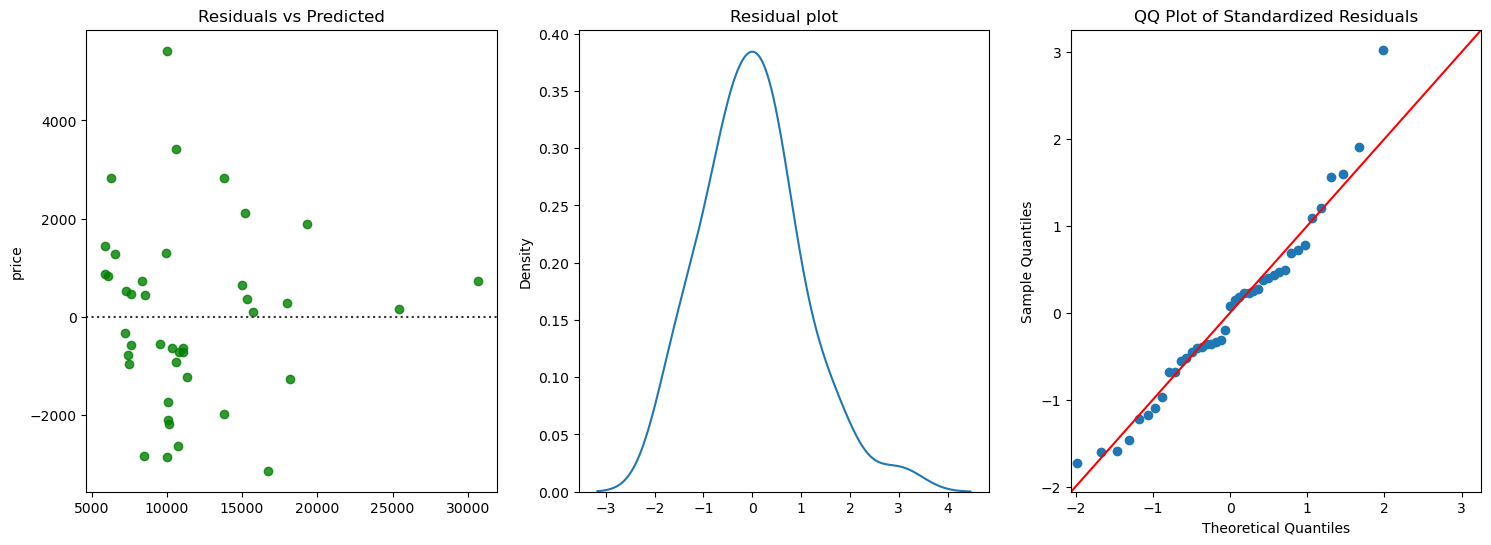

In [66]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2',groups=X_train["aspiration"])
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test,groups=X_test["aspiration"])
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
plt.show()

### Model Performance Summary

#### Cross-Validation Results
- **Test Scores**: [0.93290295, 0.88383671, 0.90748811, 0.85664129, 0.70868438]
- **Training Scores**: [0.91639638, 0.92832309, 0.92201459, 0.93056903, 0.94311234]
- **Mean Test Score**: 0.8579106897275783
- **Standard Deviation of Test Scores**: 0.0787705783311723

#### Holdout Set Performance
- **Mean Absolute Error (MAE)**: 2824.8914378539157
- **R-squared (R²)**: 0.7757703513052352
- **Adjusted R-squared**: 0.7150414881170697

### Insights
- **Consistency**: Cross-validation test scores show improved consistency with a mean R² of 0.8579 and a standard deviation of 0.0788, indicating moderate variability across different folds.
- **Overfitting**: The training scores (average ~0.928) are slightly higher than the test scores (average ~0.858), suggesting a reduced level of overfitting compared to previous results.
- **Error Magnitude**: The MAE of 2824.89 on the holdout set indicates a further improvement in prediction accuracy, with the model's predictions deviating from the actual values by an average of approximately 2824 units.
- **Holdout Set R²**: An R² of 0.7758 on the holdout set shows the model explains approximately 77.58% of the variance in the holdout data, indicating a strong fit.
- **Adjusted R²**: The adjusted R² of 0.7150 on the holdout set suggests that when accounting for the number of predictors, the model explains around 71.50% of the variance, showing further improvement in explanatory power while considering model complexity.
